In [16]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from numpy import savetxt
import random
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score,roc_auc_score,roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [27]:
df = pd.read_excel('/home/charun/Desktop/moratuwa_project/text/cartoonConvoTraining.xlsx', engine='openpyxl')
df.head(5)

,PhraseNo,Phrase,IsHateSpeech,Score
0,1,"Yes, you! Baboon, baboon, baboon, baboon!",YES,1.0
1,2,"Did you hear that, Marge? She called me a babo...",YES,1.0
2,3,Nuts.,YES,1.0
3,4,Mmm... hors doovers.,YES,1.0
4,5,You stink! You and your whole lousy operation ...,YES,1.0


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] large_grammars...... Large context-free and feature-based grammars
                           for parser comparison
  [ ] maxent_ne_chunker... ACE Named Entity Chunker (Maximum entropy)
  [ ] maxent_treebank_pos_tagger Treebank Part of Speech Tagger (Maximum entropy)
  [ ] mte_teip5........... MULTEXT-East 1984 annotated corpus 4.0
  [ ] mwa_ppdb............ The monolingual word aligner

True

In [28]:
import nltk 
nltk.download('punkt', 'stopwords')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


False

In [29]:
df = df.drop(columns=['PhraseNo', 'IsHateSpeech'],axis=1)
df = df.dropna()
df


,Phrase,Score
0,"Yes, you! Baboon, baboon, baboon, baboon!",1.0
1,"Did you hear that, Marge? She called me a babo...",1.0
2,Nuts.,1.0
3,Mmm... hors doovers.,1.0
4,You stink! You and your whole lousy operation ...,1.0
...,...,...
1562,"No, you just have to save me. \n",0.0
1563,Kyle! No!\n,0.0
1564,We are gathered here to say goodbye to four ki...,0.0
1565,"Oh Jesus, here we go again. \n",0.0


,level_0,index,Phrase,Score
0,160,719,"Screw you, hippie!\n",1.0
1,1182,635,"Your parents are dead? Goddamn, you suck, Pip!",1.0
2,604,1024,"Right right, w-would, would you like red or wh...",0.0
3,690,1378,Gary who?! What is your last name?!\n,0.0
4,1027,527,"Sir, we actually don't give two shits about yo...",1.0
...,...,...,...,...
1559,833,156,You... bastards...,1.0
1560,402,8,"Uh, my name's Willie, and all I do is get drun...",1.0
1561,925,865,"Uh, hi. Our friend joined your club a while ba...",0.0
1562,674,62,"Don't belittle my people, you fucking fatass!",1.0


In [30]:


def form_sentence(tweet):
    tweet = re.sub(r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", '', tweet)
    tweet = re.sub(r'<[^>]+>', '', tweet)
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)


def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess


def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet


Final_words = [] 


for data in df['Phrase']:
    filtered = normalization(no_user_alpha(form_sentence(data)))
    word_Final = ' '.join(filtered)
    Final_words.append(word_Final)

final_bodyTrain = pd.DataFrame(Final_words, columns=['body'])

In [31]:

final_bodyTrain

,body
0,Yes Baboon baboon baboon baboon
1,hear Marge call baboon stupidest ugliest smell...
2,Nuts
3,Mmm hors doovers
4,stink whole lousy operation stink quit
...,...
1559,save
1560,Kyle
1561,gather say goodbye four kid try help end could...
1562,Oh Jesus go


In [32]:
token = Tokenizer()
token.fit_on_texts(final_bodyTrain['body'])

#integer encode the documents
seq = token.texts_to_sequences(final_bodyTrain['body'])

# pad the document

max_length = 100
pad_seq = pad_sequences(seq, maxlen=max_length, padding='post')

#test set

#test_data = token.texts_to_sequences(final_bodyTest['body'])
#testing_seq = pad_sequences(test_data, maxlen = max_length, padding= 'post')


vocab_size = len(token.word_index) +1

#load the embedding layer

embedding_vector = {}

f = open('/home/charun/Desktop/moratuwa_project/text/glove.6B/glove.6B.100d.txt')
 
for line in tqdm(f):
  value = line.split(' ')
  word = value[0]
  coef = np.array(value[1:], dtype = 'float32')
  embedding_vector[word] = coef


# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

400000it [00:17, 22740.17it/s]
100%|██████████| 2417/2417 [00:00<00:00, 291772.42it/s]


In [33]:
y = df['Score']
y = np.array(y)
y = to_categorical(y)

y.shape

(1564, 2)

In [34]:



#define the model

model = Sequential()
model.add(Embedding(vocab_size, 100, weights = [embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.5)))
model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.summary()


model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    #metrics = [tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])


history = model.fit(
    pad_seq, y, 
    batch_size = 32,
    epochs = 50,
    #validation_data = (testing_seq, tweet_test['sentiment']),
    validation_split = 0.3
    
    #allbacks = [callback]
)

model.save('/home/charun/Desktop/moratuwa_project/text/text_model.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          241800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 18        
Total params: 404,226
Trainable params: 162,426
Non-trainable params: 241,800
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 9s 179ms/step - loss: 0.7995 - accuracy: 0.6162 - val_lo

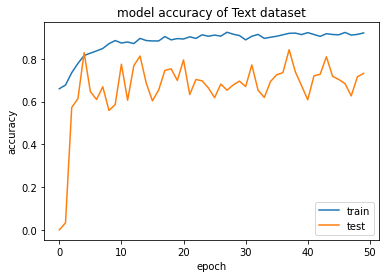

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy of Text dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

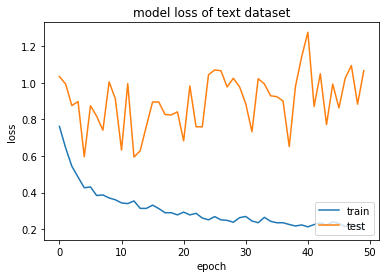

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss of text dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
!pip install numpy==1.19.5

In [70]:
!pip install moviepy

     |████████████████████████████████| 389kB 101kB/s eta 0:00:01
     |████████████████████████████████| 3.3MB 1.3MB/s eta 0:00:01
     |████████████████████████████████| 26.9MB 3.1MB/s eta 0:00:01
  Stored in directory: /home/charun/snap/jupyter/6/.cache/pip/wheels/e0/fe/1c/f4e6dca9e828d4b979c04e461d7fcc5b8e7bd35f947e665b65
  Stored in directory: /home/charun/snap/jupyter/6/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog


In [71]:
import moviepy.editor as mp

video = mp.VideoFileClip(r"/home/charun/Desktop/moratuwa_project/text/videoplayback.mp4")
video.audio.write_audiofile(r"/home/charun/Desktop/moratuwa_project/text/output.wav")



chunk:   8%|▊         | 141/1688 [00:00<00:01, 1408.90it/s, now=None]

MoviePy - Writing audio in /home/charun/Desktop/moratuwa_project/text/output.wav


MoviePy - Done.


In [73]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#get_ipython().system('pip install ibm_watson')
#!brew install ffmpeg


# In[2]:


import subprocess
from ibm_watson import SpeechToTextV1
from ibm_watson.websocket import RecognizeCallback, AudioSource
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator


# In[3]:


#Extract Audio
#command = 'ffmpeg -i video1.mp4 -ab 160k -ar 44100 -vn audioff1.wav'
#subprocess.call(command, shell=True)


# In[4]:


#set up IBM Watson speech to text
#free 500mins per month
apikey = 'kLzsZvZdSCzPFnhLgl8MBnHyfHWaFu5P7TqjBDoOnoPD'
url = 'https://api.us-south.speech-to-text.watson.cloud.ibm.com/instances/cc020a5a-49db-4e57-8c25-2dc232ec0eba'


# In[5]:


# Setup service
authenticator = IAMAuthenticator(apikey)
#create a new IAM Authenticator and pass the API key
stt = SpeechToTextV1(authenticator=authenticator)
#create new speech totext service
stt.set_service_url(url)
#set the service url


# In[6]:


with open('/home/charun/Desktop/moratuwa_project/text/output.wav', 'rb') as f:
    #opening the audio file
    res = stt.recognize(audio=f, content_type='audio/wav', model='en-AU_NarrowbandModel', continuous=True).get_result()
    #use recognize method in speech to text service to convert the audio to text



text = [result['alternatives'][0]['transcript'].rstrip() + '.\n' for result in res['results']]


text = [para[0].title() + para[1:] for para in text]
transcript = ''.join(text)
with open('output.txt', 'w') as out:
    out.writelines(transcript)


print(transcript)








ApiException: Error: <HTML><HEAD>
<TITLE>Internal Server Error</TITLE>
</HEAD><BODY>
<H1>Internal Server Error - Write</H1>
The server encountered an internal error or misconfiguration and was unable to
complete your request.<P>
Reference&#32;&#35;4&#46;14a6d67d&#46;1619585834&#46;1980a859
</BODY></HTML>
, Code: 503

In [64]:
import tensorflow

model_path = '/home/charun/Desktop/moratuwa_project/text/text_model.h5'
word = 'love'

model = tensorflow.keras.models.load_model(model_path)
#pred = model.predict(np.array([word]))

In [65]:
token = Tokenizer()
token.fit_on_texts([word])

#integer encode the documents
seq = token.texts_to_sequences([word])

# pad the document

max_length = 100
pad_seq = pad_sequences(seq, maxlen=max_length, padding='post')



In [66]:
seq

[[1]]

In [67]:
pred = model.predict(pad_seq)
pred

array([[0.59722686, 0.37479907]], dtype=float32)

In [68]:
classes = np.argmax(pred, axis = 1)
print(classes)
#value = classes[0]
#print(value)

[0]
